In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/digipodium/Datasets/main/regression/house_pricing.csv")
df.head()

,City,Type,Beds,Baths,SquareFeet,Price
0,SACRAMENTO,Residential,2,1,836,138159.85
1,SACRAMENTO,Residential,3,1,1167,167541.46
2,SACRAMENTO,Residential,2,1,796,119095.12
3,SACRAMENTO,Residential,2,1,852,130904.95
4,SACRAMENTO,Residential,2,1,797,120266.19


In [3]:
df.isnull().sum()

City          0
Type          0
Beds          0
Baths         0
SquareFeet    0
Price         0
dtype: int64

In [4]:
df.nunique()

City           36
Type            3
Beds            7
Baths           5
SquareFeet    602
Price         814
dtype: int64

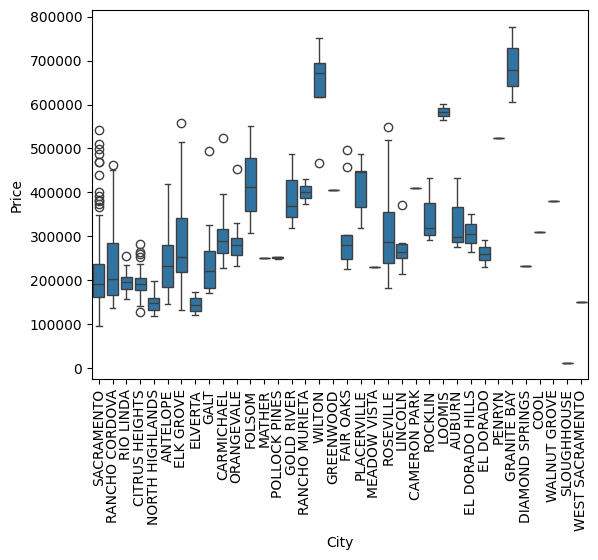

In [5]:
sns.boxplot(data=df, x='City', y='Price')
plt.xticks(rotation=90)
plt.show()

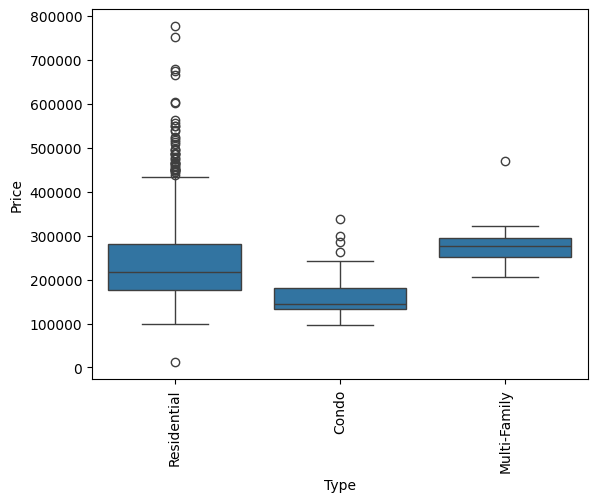

In [6]:
sns.boxplot(data=df, x='Type', y='Price')
plt.xticks(rotation=90)
plt.show()

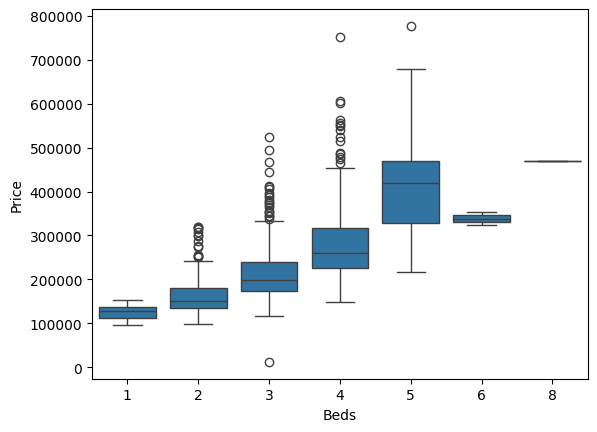

In [7]:
sns.boxplot(data=df, x='Beds', y='Price')
plt.show()

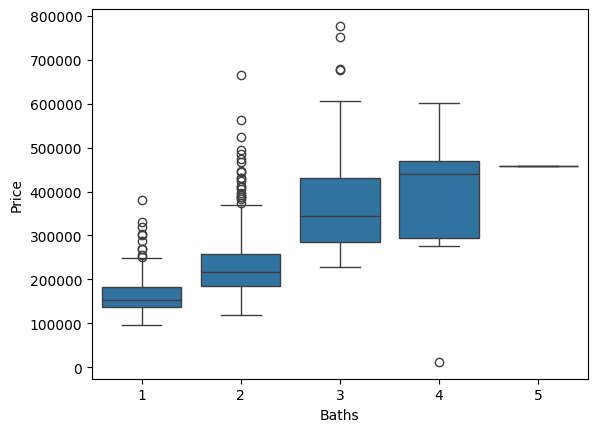

In [8]:
sns.boxplot(data=df, x='Baths', y='Price')
plt.show()

<Axes: xlabel='SquareFeet', ylabel='Price'>

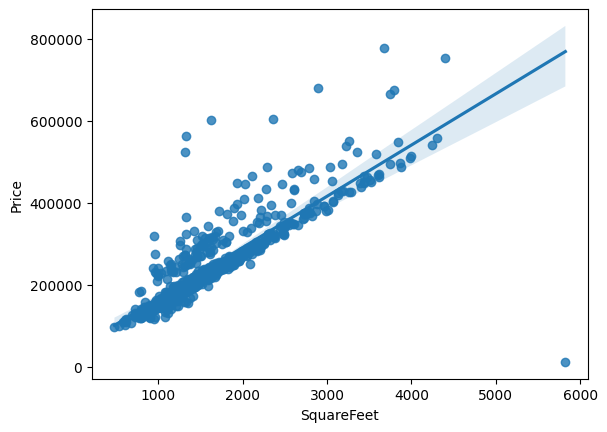

In [9]:
sns.regplot(data=df, x='SquareFeet', y='Price')

# pipeline

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [11]:
text_cols = ['Type']
num_cols = ['SquareFeet', 'Beds', 'Baths']

X = df[text_cols + num_cols]
y = df['Price']

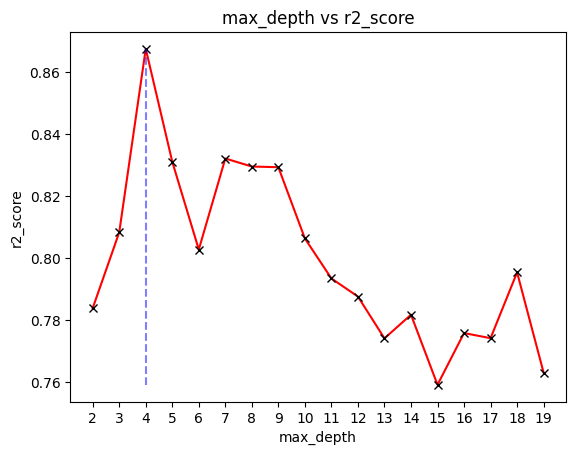

In [12]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, 
    test_size=0.2, 
    random_state=0)
cat_pipe = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first'))
])
num_pipe = Pipeline(steps=[
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, text_cols)
])
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('reg', DecisionTreeRegressor())
])
# max_depth
scores = []
for i in range(2, 20):
    model.named_steps['reg'].set_params(max_depth=i)
    model.fit(Xtrain, ytrain)
    ypred = model.predict(Xtest)
    scores.append(r2_score(ytest, ypred))
plt.plot(range(2, 20), scores, marker='x', color='red', markeredgecolor='black')
plt.vlines(x=4, ymin=min(scores), ymax=max(scores), color='blue', linestyle='--',
        alpha=0.5)
plt.title('max_depth vs r2_score')
plt.xlabel('max_depth')
plt.ylabel('r2_score')
plt.xticks(range(2, 20))
plt.show()

In [13]:
ypred = model.predict(Xtest)
print('R2:', r2_score(ytest, ypred))
print('MAE:', mean_absolute_error(ytest, ypred))
print('MSE:', mean_squared_error(ytest, ypred))

R2: 0.7631376286014669
MAE: 27935.631953987733
MSE: 2153532930.0377803


# Grid Search

In [14]:
from sklearn.model_selection import GridSearchCV

In [15]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, 
    test_size=0.2, 
    random_state=0)
cat_pipe = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first'))
])
num_pipe = Pipeline(steps=[
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, text_cols)
])
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('reg', DecisionTreeRegressor())
])
param_grid = {
    'reg__criterion': ['sqaured_error', 'friedman_mse', 'absolute_error'],
    'reg__max_depth': range(2, 20),
    'reg__ccp_alpha': np.linspace(0.0, 0.1, 10)
}
# neg_mean_squared_error because scoring is opposite of loss
grid = GridSearchCV(model, param_grid, 
                    scoring='r2',
                    cv=4, 
                    verbose=1, 
                    n_jobs=-1)
grid

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['SquareFeet',
                                                                          'Beds',
                                                                          'Baths']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['Type'])])),
                                       ('reg', DecisionTreeRegressor())]),
             n_jobs=-1,
             param_grid={'reg__ccp_alpha': array([0.        , 0.01111111, 0.02222222, 0.03333333, 0.04444444,
       0.05555556, 0.06666667, 0.07777778, 0.08888889, 0.1       ]),
                         'reg__criterion': ['sqaured_error', 'friedman_mse',
                                            'absolute_error'],
                         'reg__max_depth': range(2, 20)},
             scoring='r2', verbose=1)

In [16]:
grid.fit(X, y)

Fitting 4 folds for each of 540 candidates, totalling 2160 fits


c:\Users\ZAID\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
720 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
42 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ZAID\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ZAID\miniconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ZAID\miniconda3\Lib\site-packages\sklearn\pipeline.py", line 473, in fit
    self._final_estimator.

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['SquareFeet',
                                                                          'Beds',
                                                                          'Baths']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['Type'])])),
                                       ('reg', DecisionTreeRegressor())]),
             n_jobs=-1,
             param_grid={'reg__ccp_alpha': array([0.        , 0.01111111, 0.02222222, 0.03333333, 0.04444444,
       0.05555556, 0.06666667, 0.07777778, 0.08888889, 0.1       ]),
                         'reg__criterion': ['sqaured_error', 'friedman_mse',
                                            'absolute_error'],
                         'reg__max_depth': range(2, 20)},
             scoring='r2', verbose=1)

In [17]:
results = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')

In [18]:
grid.best_params_

{'reg__ccp_alpha': 0.0,
 'reg__criterion': 'absolute_error',
 'reg__max_depth': 4}

In [19]:
final_model = grid.best_estimator_

In [20]:
# ypred = final_model.predict(Xtest)
# print('R2:', r2_score(ytest, ypred))
# print('MAE:', mean_absolute_error(ytest, ypred))
# print('MSE:', mean_squared_error(ytest, ypred))

<Axes: xlabel='rank_test_score', ylabel='mean_test_score'>

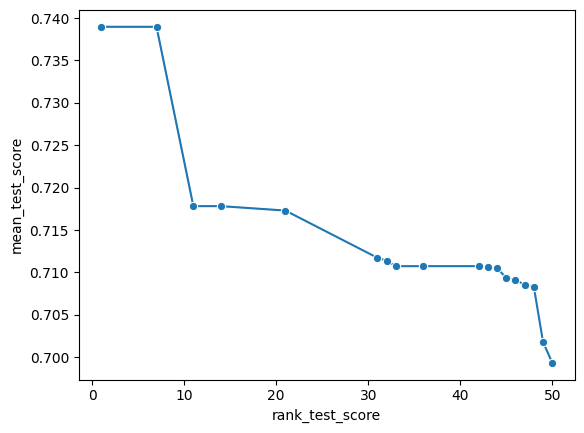

In [21]:
sns.lineplot(data=results.head(50), x='rank_test_score', y='mean_test_score', marker='o')

<Axes: xlabel='mean_test_score', ylabel='Count'>

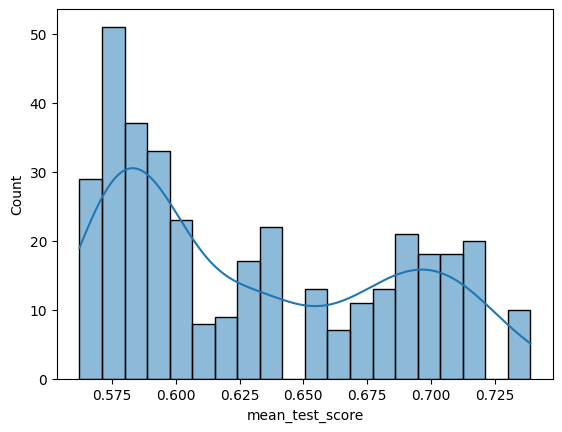

In [22]:
sns.histplot(data=results, x='mean_test_score', bins=20, kde=True)

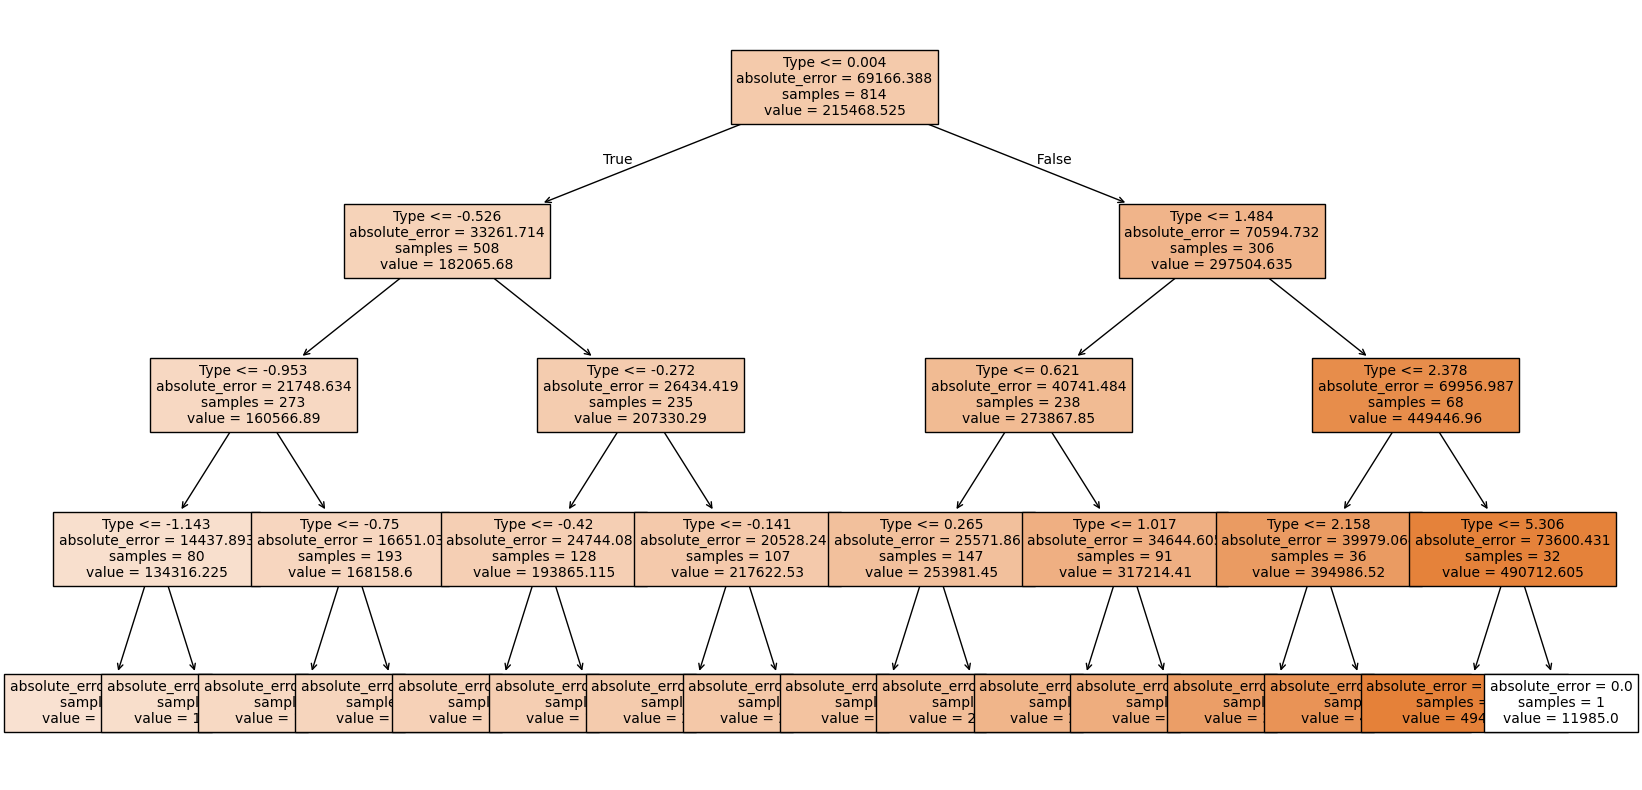

In [23]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(final_model.named_steps['reg'], 
        feature_names=X.columns, 
        filled=True, 
        fontsize=10)
plt.show()

validation_curve and learning curve

In [24]:
df = pd.read_csv('../datasets/housing.csv')
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

<Axes: xlabel='ocean_proximity', ylabel='median_house_value'>

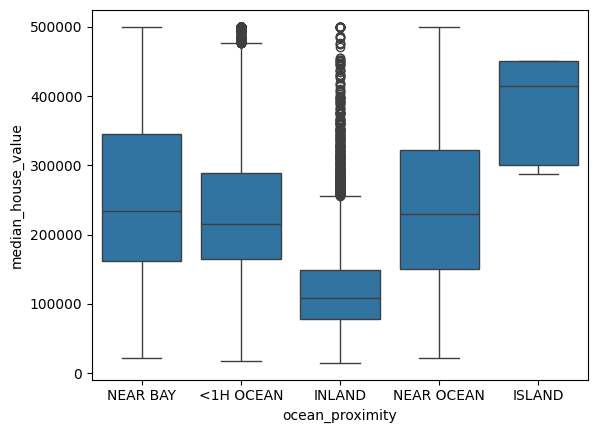

In [25]:
sns.boxplot(data=df, x='ocean_proximity', y='median_house_value')

In [26]:
X = df.drop(columns=['median_house_value','ocean_proximity'])
y = df['median_house_value']

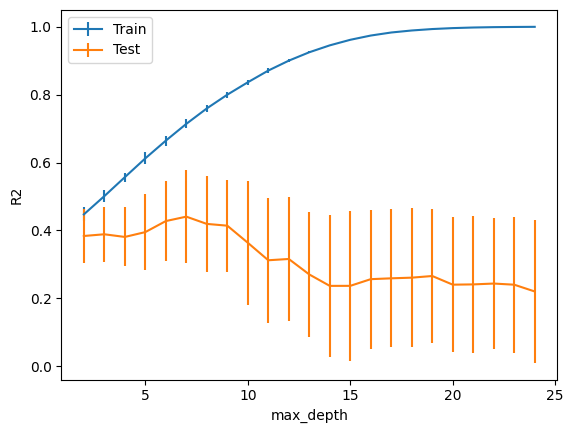

In [27]:
from sklearn.model_selection import ValidationCurveDisplay
max_depths = list(range(2, 25))
disp = ValidationCurveDisplay.from_estimator(
    DecisionTreeRegressor(),
    X,y,
    param_name='max_depth',
    param_range=max_depths,
    scoring='r2',
    n_jobs=-1,
    std_display_style='errorbar'
)

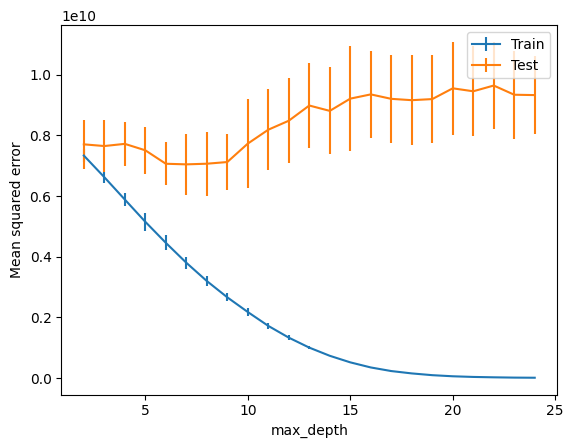

In [28]:
from sklearn.model_selection import ValidationCurveDisplay
max_depths = list(range(2, 25))
disp = ValidationCurveDisplay.from_estimator(
    DecisionTreeRegressor(),
    X,y,
    param_name='max_depth',
    param_range=max_depths,
    scoring='neg_mean_squared_error',
    negate_score=True,
    n_jobs=-1,
    std_display_style='errorbar'
)

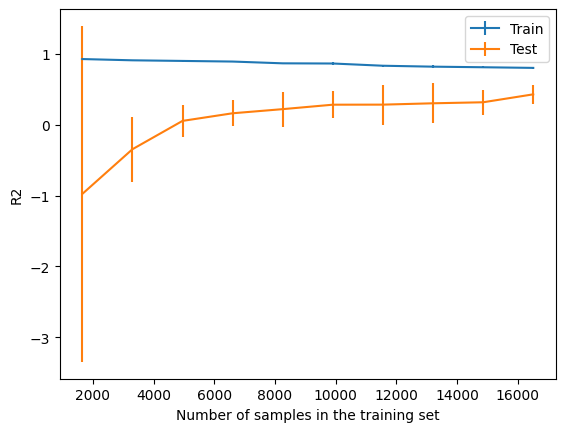

In [29]:
from sklearn.model_selection import LearningCurveDisplay

disp = LearningCurveDisplay.from_estimator(
    DecisionTreeRegressor(max_depth=9),
    X,y,
    scoring='r2',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    std_display_style='errorbar'
)

In [30]:
from sklearn.model_selection import learning_curve

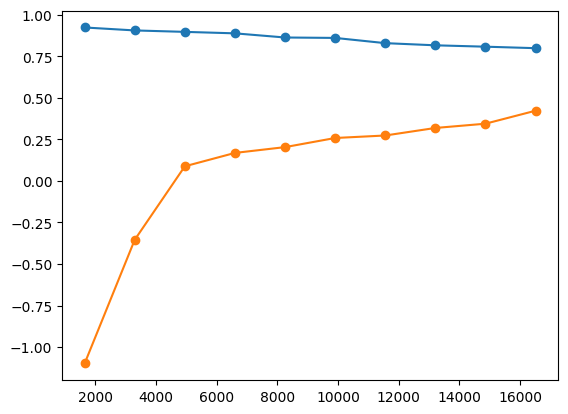

In [31]:
results = learning_curve(
    DecisionTreeRegressor(max_depth=9),
    X,y,
    scoring='r2',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_sizes, train_scores, test_scores = results
plt.plot(train_sizes, train_scores.mean(axis=1), marker='o', label='train')
plt.plot(train_sizes, test_scores.mean(axis=1), marker='o', label='test')